# 2D Pose Estimation - UNet Architecture

## Based on [Keras Implementation for Biomedical Image Segmentation](https://github.com/zhixuhao/unet)

## Imports 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.metrics import Precision, Recall

# WandB
import h5py, wandb
from wandb.keras import WandbCallback

In [2]:
# Relative Imports
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from lib import utils, generators, losses, metrics
from lib.models.unet_simple import unet_simple

/home/jupyter/thirdeye


## Parameters

In [3]:
# On low RAM, machine, Use Generator for Data Input
# For high RAM machine, Load Full Dataset into RAM
USE_GENERATOR = True

# Set to True to Test Data Generator with Keypoints Image Plots
TEST_GENERATOR = False

IMAGE_RESOLUTION = 256 # Image Shape (int)

KEYPOINT_RADIUS = 5 # Keypoint Radius for Binary Classification Loss

BATCH_SIZE = 8

NUM_SAMPLES = 2600 # Max = 56636, From h5 File
NUM_VAL_SAMPLES = 400 # Max = 2366, From h5 File

EPOCHS = 3

LOSS_TYPE ='bce_logisticloss' # Write str of Loss Function Used

METRICS_THRESHOLD = 0.2

METRICS = [Precision(thresholds=METRICS_THRESHOLD), Recall(thresholds=METRICS_THRESHOLD)]

LEARNING_RATE = 'Adam Standard'
DECAY = 'Adam Standard'
OPTIMIZER = Adam()

WANDB = True # Boolean whether or not to log in Weights and Biases
PROJECT_NAME = 'unet-2d-pose'
RUN_NAME = '3k_b8_pynb'
NOTES = '3k Sample Test from Notebook'
MODEL = 'UNet'
DATA = 'COCO'

desired_joints = ['left_shoulder',
                  'right_shoulder',
                  'left_elbow',
                  'right_elbow',
                  'left_wrist',
                  'right_wrist',
                  'left_hip',
                  'right_hip',
                  'left_knee',
                  'right_knee',
                  'left_ankle',
                  'right_ankle'
                 ]

VMIN = 0.01 # Colormap Lower Cutoff for Displaying Heatmaps
CMAP = plt.get_cmap('hsv')
CMAP.set_under('k', alpha=0)

### Weights and Biases

In [4]:
if WANDB == True:
    wandb.init(project=PROJECT_NAME,
               notes=NOTES,
               name=RUN_NAME,
               resume=False,
               )
    wandb.config.update({
        "model": MODEL,
        "data": DATA,
        "use_generator": USE_GENERATOR,
        "img_resolution": IMAGE_RESOLUTION,
        "loss": str(LOSS_TYPE),
        "metrics": METRICS,
        "metrics_threshold": METRICS_THRESHOLD,
        "samples": NUM_SAMPLES,
        "val_samples": NUM_VAL_SAMPLES,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "optimizer": str(OPTIMIZER),
        "lr": str(LEARNING_RATE),
        "decay": str(DECAY),
        "keypoint_radius": KEYPOINT_RADIUS,
        })
    wandb_callback = WandbCallback(
            save_model=False,
            monitor='loss',
            mode='auto',
            )

## Load Datasets


In [5]:
# Load h5 File
h5_train_data = h5py.File('../data/coco_train_256_x56637.h5', 'r')
h5_val_data = h5py.File('../data/coco_val_256_x2366.h5', 'r')
print(list(h5_train_data.attrs.keys()))

['jointnames']


#### Sort Desired Joints from h5 Input

In [6]:
# Joints List from h5 Input
input_joints = list(h5_train_data.attrs['jointnames'])

# Create List of Original Input Indices
joint_input_indices = []
for i in input_joints:
    for d in desired_joints:
        if i == d:
            joint_input_indices.append(input_joints.index(i))

print(joint_input_indices)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## Test Data from h5





In [7]:
if TEST_GENERATOR == True:
    # Create Data Generators
    training_generator = generators.h5_generator(h5_train_data, batch_size=BATCH_SIZE,
                                      joint_input_indices=joint_input_indices,
                                      image_resolution=IMAGE_RESOLUTION, 
                                      keypoint_radius=KEYPOINT_RADIUS)

    val_generator = generators.h5_generator(h5_val_data, batch_size=BATCH_SIZE,
                                      joint_input_indices=joint_input_indices,
                                      image_resolution=IMAGE_RESOLUTION, 
                                      keypoint_radius=KEYPOINT_RADIUS)

    print('Finished Creating Generators')

    # Get Sample Batch
    batch_number = 0
    [ batch_x, batch_y ] = training_generator.__getitem__(batch_number)
    batch_x, batch_y = batch_x.astype(float) , batch_y.astype(float)
    print('Img Batch: {}'.format(batch_x.shape))
    print('Keypoints Batch: {}'.format(batch_y.shape))

    # Test Sample Keypoints Heatmap
    iteration_number = 0
    plt.imshow(batch_x[iteration_number, :, :])

    joint_number = 0
    print(desired_joints[joint_number])
    print('Min Val: {}'.format(np.amin(batch_y[iteration_number, :, :, joint_number])))
    print('Max Val: {}'.format(np.amax(batch_y[iteration_number, :, :, joint_number])))
    if np.amax(batch_y[iteration_number, :, :, joint_number]) != 0:
        plt.imshow(batch_y[iteration_number, :, :, joint_number], cmap=CMAP, vmin=0.1)
    plt.gcf().set_size_inches(6, 6)

In [8]:
if TEST_GENERATOR == True:
    # Overlay all Joints on Original Image
    plt.imshow(batch_x[iteration_number, :, :])

    for keypoint in range(len(desired_joints)):
      # If Keypoint Exists in image
      if np.amax(batch_y[iteration_number, :, :, keypoint]) != 0:
        plt.imshow(batch_y[iteration_number, :, :, keypoint], cmap=CMAP, vmin=VMIN)
    plt.gcf().set_size_inches(6, 6)

## UNet Model

In [9]:
model = unet_simple(input_shape = (IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), \
                     output_num = len(desired_joints))

model.compile(optimizer = OPTIMIZER, loss = losses.customLoss(), 
              metrics = METRICS)

# Print Full Model Summary
#model.summary()

## Train Model

In [10]:
# Use Generator to Load All Data into Tensors
if USE_GENERATOR == True:
    batch_train = BATCH_SIZE
    batch_val = BATCH_SIZE
if USE_GENERATOR == False:
    batch_train = NUM_SAMPLES
    batch_val = NUM_VAL_SAMPLES
    
training_generator = generators.h5_generator(h5_train_data, batch_size=batch_train,
                              joint_input_indices=joint_input_indices,
                              image_resolution=IMAGE_RESOLUTION, 
                              keypoint_radius=KEYPOINT_RADIUS)
val_generator = generators.h5_generator(h5_val_data, batch_size=batch_val,
                              joint_input_indices=joint_input_indices,
                              image_resolution=IMAGE_RESOLUTION, 
                              keypoint_radius=KEYPOINT_RADIUS)

CALLBACKS = []

if WANDB == True:
    CALLBACKS.append(wandb_callback)

if USE_GENERATOR == True:
    model.fit_generator(
                        generator=training_generator,
                        steps_per_epoch=int(NUM_SAMPLES/BATCH_SIZE),
                        validation_data=val_generator,
                        validation_freq=1,
                        validation_steps=int(NUM_VAL_SAMPLES/BATCH_SIZE),
                        epochs=EPOCHS,
                        callbacks=CALLBACKS,
                        )

elif USE_GENERATOR == False:
    # Train Model
    model.fit(x=training_generator.load_data(0,0), y=training_generator.load_data(0,1), batch_size=BATCH_SIZE, 
          epochs=EPOCHS, callbacks=CALLBACKS,
          validation_data=val_generator.__getitem__(0),
          shuffle=True, verbose=1,
             )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 325 steps, validate for 50 steps
Epoch 1/3
325/325 [==============================] - 212s 653ms/step - loss: 0.0639 - precision: 0.0011 - recall: 0.0055 - val_loss: 0.0144 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
325/325 [==============================] - 199s 612ms/step - loss: 0.0132 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3
325/325 [==============================] - 199s 612ms/step - loss: 0.0129 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0142 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


# Prediction

### Choose Image

1/1 [==============================] - 1s 1s/sample
--Joint 1--
Min Val: 1.9093301700974508e-13
Max Val: 0.05920572578907013
--Joint 2--
Min Val: 2.6897023020291955e-13
Max Val: 0.055275045335292816


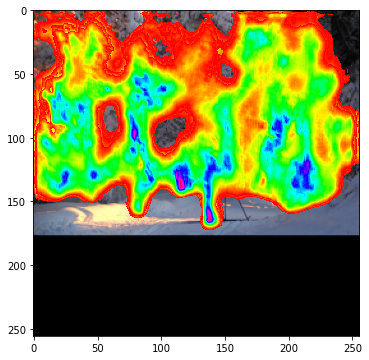

In [11]:
# Get Random Index in h5 File
pred_generator = generators.h5_generator(h5_val_data, batch_size=1,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)

# Predict Image Joints from Sample
predictions = model.predict(pred_generator.load_data(0,0), verbose=1)

# Retrieve Index from Image Tensor
pred_img = pred_generator.load_data(0,0)[0,:]
# Get Corresponding Keypoints
pred_heatmaps = predictions[0,:]

# Overlay all Joints on Original Image
plt.imshow(pred_img)

for keypoint in range(len(desired_joints)):
    # If Keypoint Exists in image
    if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
        plt.imshow(pred_heatmaps[:, :, keypoint], cmap=CMAP, vmin=VMIN)
    
plt.gcf().set_size_inches(6, 6)
    
# Print Prediction Array Stats
# for joint in range(len(desired_joints)):
for joint in range(2):
    print('--Joint {}--'.format(joint+1))
    print('Min Val: {}'.format(np.amin(predictions[0, :, :, joint])))
    print('Max Val: {}'.format(np.amax(predictions[0, :, :, joint])))

if WANDB == True:
    wandb.log({"Full Heatmap": plt})

left_shoulder


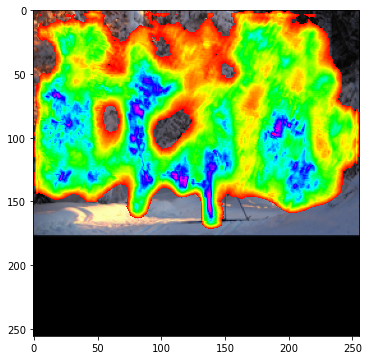

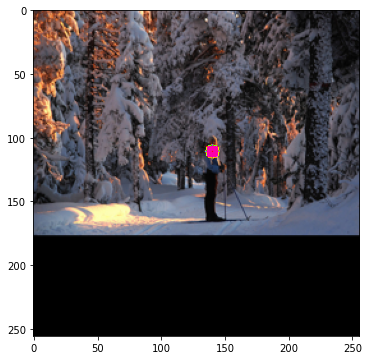

In [12]:
# Choose Joint
joint = 0
print(desired_joints[joint])

plt.imshow(pred_img)

# HeatMap
if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
    plt.imshow(predictions[0, :, :, joint], cmap=CMAP, vmin=VMIN)
else:
    print('Heatmap Plot Error: Max Value in Prediction is {}'.format(np.amax(predictions[0, :, :, joint])))
    print('Heatmap Error: in Prediction is {}'.format(np.amin(predictions[0, :, :, joint])))
plt.gcf().set_size_inches(6, 6)

# Display True Keypoints
plt.figure()
plt.imshow(pred_img)
if np.amax(pred_generator.load_data(0,1)[0, :, :, joint]) != 0:
    plt.imshow(pred_generator.load_data(0,1)[0, :, :, joint], cmap=CMAP, vmin=VMIN)
plt.gcf().set_size_inches(6, 6)

# Save Model

In [ ]:
# Export TF SavedModel
save_model(
    model, ('../SavedModels/' + PROJECT_NAME + '/' + RUN_NAME), overwrite=True, include_optimizer=True,
    signatures=None, options=None
)

In [ ]:
# Copy SavedModel to GCS in Terminal (Ingored from Git)
# Copy to Bucket (Project: thirdeye) /models-thirdeye/unet-2d-pose/model_name